In [1]:
import pandas as pd
import numpy as np
from gnn import GAT
import snf
from torch_geometric.utils import to_edge_index
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler


In [2]:
clinical_path = "data_SALMON/clinical.csv"

clinical = pd.read_csv(clinical_path, index_col=0)
clinical

,Sex,Age,ER_Status,PR_Status,OS_Months,OS_Status
TCGA-A1-A0SB,Female,70,Positive,Negative,8.51,LIVING
TCGA-A1-A0SD,Female,59,Positive,Positive,14.36,LIVING
TCGA-A1-A0SF,Female,54,Positive,Positive,48.06,LIVING
TCGA-A1-A0SG,Female,61,Positive,Positive,14.26,LIVING
TCGA-A1-A0SI,Female,52,Positive,Positive,20.86,LIVING
...,...,...,...,...,...,...
TCGA-OL-A66J,Female,80,Positive,Positive,65.57,LIVING
TCGA-OL-A66K,Female,72,Positive,Positive,41.89,DECEASED
TCGA-PE-A5DC,Female,72,Positive,Positive,46.98,DECEASED
TCGA-PE-A5DD,Female,64,Positive,Negative,64.16,LIVING


In [3]:
clinical_data = clinical.filter(["Age","ER_Status","PR_Status"], axis=1)
clinical_data["ER_Status"] = np.where(clinical_data["ER_Status"] == "Positive", 0, 1)
clinical_data["PR_Status"] = np.where(clinical_data["PR_Status"] == "Positive", 0, 1)
clinical_data

scaler = MinMaxScaler()
clinical_data["Age"] = scaler.fit_transform(clinical_data[["Age"]])
clinical_data

,Age,ER_Status,PR_Status
TCGA-A1-A0SB,0.687500,0,1
TCGA-A1-A0SD,0.515625,0,0
TCGA-A1-A0SF,0.437500,0,0
TCGA-A1-A0SG,0.546875,0,0
TCGA-A1-A0SI,0.406250,0,0
...,...,...,...
TCGA-OL-A66J,0.843750,0,0
TCGA-OL-A66K,0.718750,0,0
TCGA-PE-A5DC,0.718750,0,0
TCGA-PE-A5DD,0.593750,0,1


In [4]:
miRNA = "data_SALMON/miRNAseq_EigengeneMatrix.csv"

miRNA = pd.read_csv(miRNA, index_col=0)
miRNA = miRNA.T
miRNA

,1,2,3,4,5,6,7,8,9,10,11,12
TCGA-A1-A0SB,-0.042420,-0.090163,-0.103699,-0.100181,0.009737,0.006873,-0.005721,0.014261,-0.046646,-0.082686,-0.057242,-0.048025
TCGA-A1-A0SD,0.026372,-0.012767,-0.019600,-0.022688,0.033921,0.010172,0.009140,0.013867,0.048973,-0.010675,0.059538,0.002266
TCGA-A1-A0SF,0.031152,0.000190,-0.002107,-0.018708,0.030067,0.035569,0.016265,-0.006071,0.023123,-0.005506,0.015255,0.017940
TCGA-A1-A0SG,-0.006429,0.005548,-0.016271,-0.064310,-0.006367,0.007869,-0.000176,-0.007992,0.033614,0.010472,0.012432,0.026925
TCGA-A1-A0SI,0.026246,-0.034655,-0.045800,-0.011842,0.042647,0.068827,-0.001606,0.026218,0.054258,0.062864,0.056124,0.034423
...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A66J,0.021061,-0.025092,-0.023694,0.022798,-0.028997,0.006727,0.007412,0.005220,-0.017438,-0.070913,-0.034328,0.003161
TCGA-OL-A66K,0.064845,-0.006999,-0.005259,0.062771,0.019843,0.060686,0.018273,0.064182,0.023687,-0.004050,0.019973,0.010058
TCGA-PE-A5DC,0.009247,0.013094,0.029231,0.043227,-0.050204,-0.063029,-0.009244,-0.018845,-0.066363,-0.051668,-0.068362,-0.022317
TCGA-PE-A5DD,0.046154,0.041091,0.048019,0.049055,-0.071419,0.042207,0.016091,0.012999,0.006519,0.034132,0.013852,0.004283


In [5]:
RNA_path = "data_SALMON/RNAseq_EigengeneMatrix.csv"

RNA = pd.read_csv(RNA_path, index_col=0)
RNA = RNA.T
RNA

,1,2,3,4,5,6,7,8,9,10,...,48,49,50,51,52,53,54,55,56,57
TCGA-A1-A0SB,-0.029602,0.020217,0.086410,0.025353,0.003537,0.040495,0.069987,0.044977,0.019823,-0.080251,...,-0.032308,-0.012952,-0.004667,-0.021261,-0.040143,0.070666,0.125235,-0.011356,0.027079,-0.037636
TCGA-A1-A0SD,-0.031283,0.024937,0.007832,0.026282,-0.024340,-0.039550,-0.020600,-0.024775,-0.009275,0.036575,...,-0.000410,0.060004,0.022528,-0.008400,-0.045517,-0.032657,-0.012987,-0.030806,0.010309,-0.013960
TCGA-A1-A0SF,0.016923,-0.030722,-0.008329,0.015331,0.000585,-0.022336,-0.023629,-0.017090,-0.039296,-0.056388,...,0.010845,-0.029011,0.058890,0.018722,0.016489,-0.040891,0.090258,0.035414,0.032379,0.003300
TCGA-A1-A0SG,0.003003,-0.026207,0.005945,0.036521,-0.019131,-0.001454,0.032431,-0.032698,-0.043137,0.020375,...,-0.067539,-0.004758,0.014531,0.036379,0.048227,-0.042269,-0.036060,0.032832,0.019316,0.059932
TCGA-A1-A0SI,-0.016968,-0.001813,-0.021719,-0.013619,-0.068450,0.003627,-0.021654,0.013146,-0.004305,0.057156,...,-0.036027,-0.003300,-0.021658,0.003259,0.015840,0.000652,0.009917,0.023690,0.029923,-0.002678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-OL-A66J,0.039831,-0.038962,0.008091,0.047684,-0.010147,-0.060708,0.032453,-0.032453,-0.029510,-0.003921,...,0.033745,-0.021973,0.022792,0.010461,0.060940,-0.039038,0.044801,0.030895,0.030901,-0.001682
TCGA-OL-A66K,0.024010,-0.034149,0.032382,0.044144,-0.009869,-0.014038,-0.059152,-0.039044,-0.061031,-0.001047,...,-0.012583,0.025824,0.037057,0.009544,-0.011804,-0.023093,0.049145,-0.037150,0.010325,0.037359
TCGA-PE-A5DC,0.039884,-0.061694,0.031874,-0.024867,0.022109,-0.049108,0.007377,-0.017424,-0.034391,-0.043093,...,0.011214,0.016659,0.024947,0.075088,0.055754,-0.045175,-0.064250,0.039267,0.007987,0.034965
TCGA-PE-A5DD,0.038224,-0.064202,-0.005512,0.017849,-0.017086,-0.068544,-0.001028,-0.010509,-0.032434,0.001309,...,0.005591,0.046423,0.103697,0.045112,-0.002951,-0.051590,0.025009,-0.028671,0.082329,-0.009017


In [6]:
CNV_path = "data_SALMON/CNV.csv"
TMB_path = "data_SALMON/TMB.csv"

CNV = pd.read_csv(CNV_path, index_col=0)
TMB = pd.read_csv(TMB_path, index_col=0)
TMB = TMB.filter(["All_TMB","All_pTNB","NonSyn_TMB","NonSyn_pTNB"], axis=1)

CNV_TMB = pd.concat([CNV["LENGTH_KB"], TMB], axis=1)
CNV_TMB

CNV_TMB = (CNV_TMB - CNV_TMB.min(axis=0)) / (CNV_TMB.max(axis=0)-CNV_TMB.min(axis=0))

In [7]:
data = pd.concat([miRNA, RNA, CNV_TMB, clinical_data], axis=1)
data = (data - data.min(axis=0)) / (data.max(axis=0)-data.min(axis=0))
data.isnull().values.any()

False

In [25]:
k = 20

data = [miRNA, RNA, CNV_TMB, clinical_data]

affinity_nets = snf.make_affinity(
    data,
    metric="sqeuclidean",
    K=k,
    mu=0.5,
)

fused_snf = snf.snf(affinity_nets, K=k)
threshold = 0.005
fused_snf[fused_snf >= threshold] = 1
fused_snf[fused_snf < threshold] = 0

edge_index = to_edge_index((torch.tensor(fused_snf, dtype=torch.long).to_sparse()))[0]
edge_index.shape

torch.Size([2, 617])

In [26]:
gt = torch.tensor(np.where(clinical["OS_Status"] == "DECEASED", 1, 0), dtype=torch.long)
gt.size()

torch.Size([583])

In [27]:
def df_to_normalised_tensor(data):
    return torch.tensor(((data - data.min(axis=0)) / (data.max(axis=0)-data.min(axis=0))).values, dtype=torch.float)

data = pd.concat([miRNA, RNA, CNV_TMB, clinical_data], axis=1)

data = df_to_normalised_tensor(data)
# data.size()
data

tensor([[0.4306, 0.3157, 0.1106,  ..., 0.6875, 0.0000, 1.0000],
        [0.7042, 0.5152, 0.3535,  ..., 0.5156, 0.0000, 0.0000],
        [0.7232, 0.5486, 0.4040,  ..., 0.4375, 0.0000, 0.0000],
        ...,
        [0.6361, 0.5819, 0.4945,  ..., 0.7188, 0.0000, 0.0000],
        [0.7829, 0.6541, 0.5488,  ..., 0.5938, 0.0000, 1.0000],
        [0.7313, 0.7553, 0.6515,  ..., 0.2344, 0.0000, 0.0000]])

Epoch  10 | Loss: 0.90 | F1: 3.79%


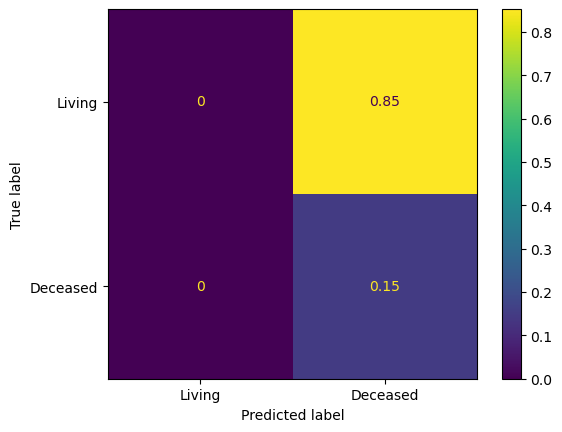

Epoch  20 | Loss: 0.77 | F1: 3.79%


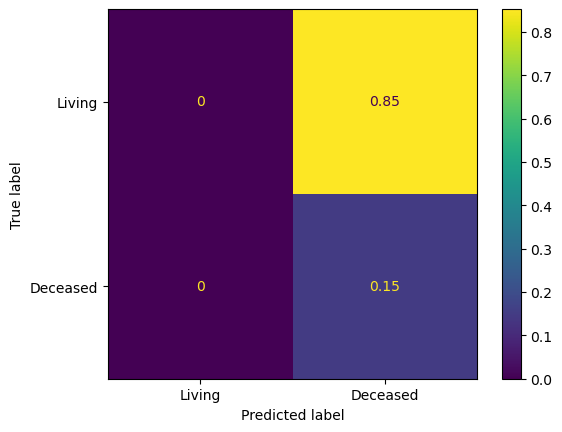

Epoch  30 | Loss: 0.75 | F1: 74.42%


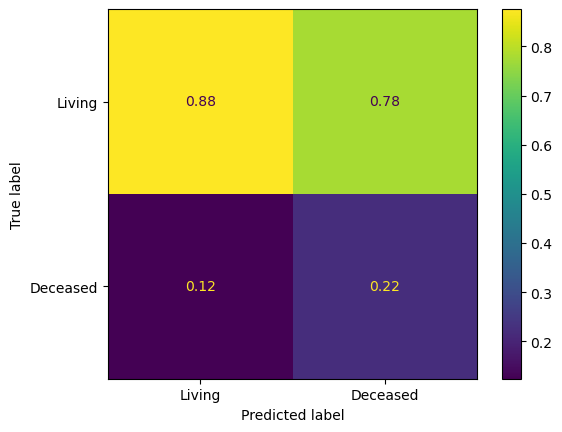

Epoch  40 | Loss: 0.70 | F1: 78.85%


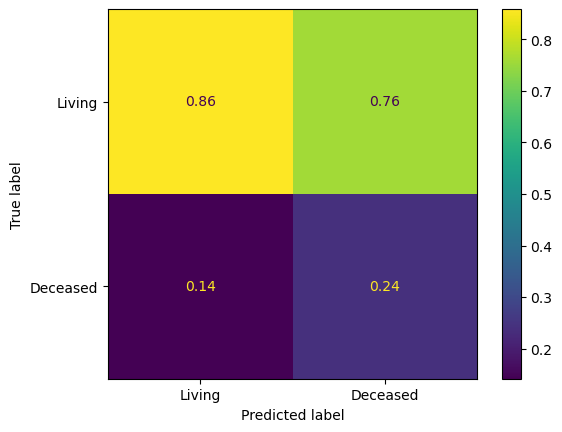

Epoch  50 | Loss: 0.70 | F1: 65.69%


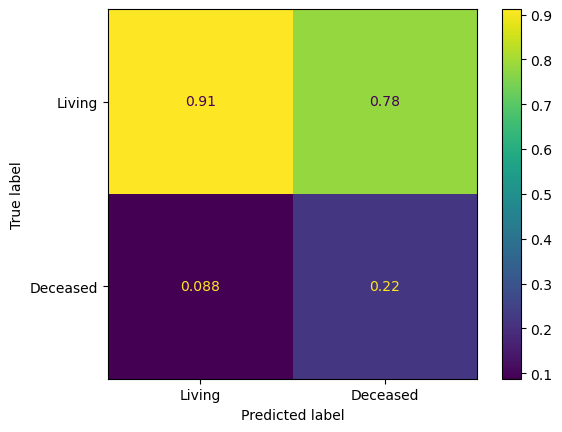

Epoch  60 | Loss: 0.68 | F1: 57.31%


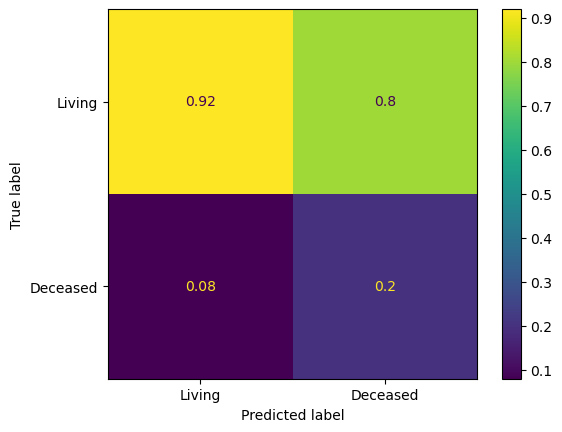

Epoch  70 | Loss: 0.68 | F1: 71.91%


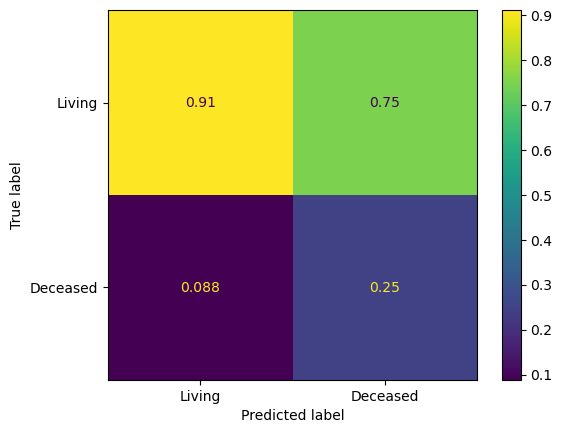

Epoch  80 | Loss: 0.69 | F1: 74.67%


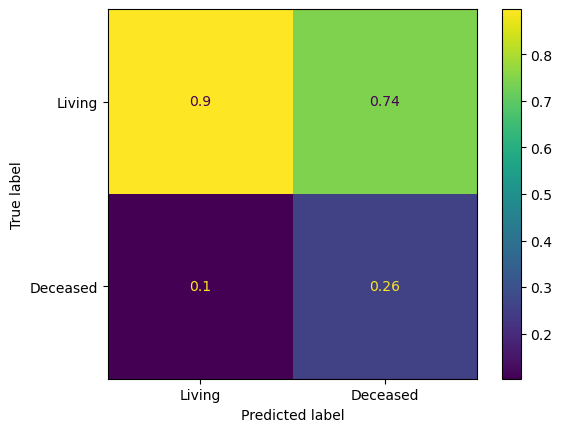

Epoch  90 | Loss: 0.67 | F1: 73.87%


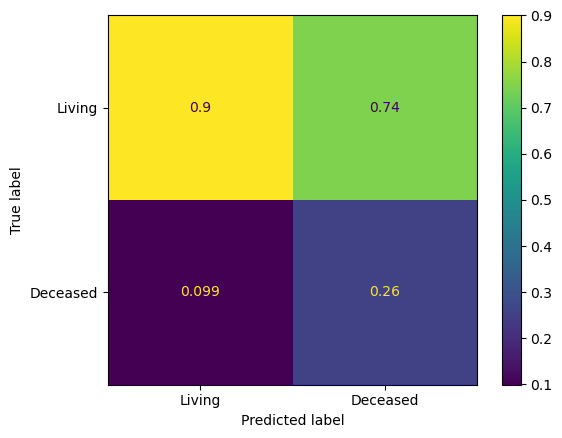

Epoch 100 | Loss: 0.67 | F1: 73.67%


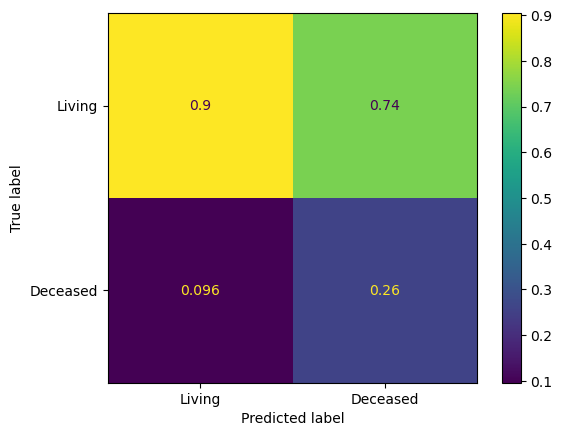

In [28]:
model_gat = GAT(data.size()[1], 20, d_p=0.4)

optimizer = torch.optim.Adam(model_gat.parameters(), lr=0.005,
                                          weight_decay=5e-4)
# Training loop
for epoch in range(100):
    # Clear gradients
    optimizer.zero_grad()

    h, loss = model_gat.forward_pass(data, edge_index, gt)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    z = model_gat.infer(data, edge_index)
    
    f1 = f1_score(gt, z.argmax(dim=1), average='weighted')

    # Print metrics every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1:>3} | Loss: {loss:.2f} | F1: {f1*100:.2f}%')
        cm = confusion_matrix(gt, z.argmax(dim=1), normalize="pred", labels=[0,1])
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Living", "Deceased"])
        cm_display.plot()
        plt.show()